In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('data/data.csv')
df.describe()

,upvotes
count,186277.000000
mean,30.910424
std,298.558384
min,-482.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,32442.000000


# Cleaning the text data

Some of the tweets were not saved in the right format (text was divided/only fetched some of the text). Hence we remove these rows from the data.

In [3]:
def clean(df): 
    data = df.copy()
    data['upvotes'] = pd.to_numeric(data['upvotes'], errors='coerce')
    data.loc[:, 'comment_body'] = data['comment_body'].replace('>“¨«»®´·º½¾¿¡§£₤‘’', '').replace('\[\S+\]', '', regex=True).replace('\(\S+\)', '', regex=True).replace('[http]{4}\S+', '', regex=True).replace('(\n|\r)+', '', regex=True)
    data = data.loc[data['comment_body'].apply(lambda x: x != ''), :]
    data = data.dropna()
    return data

In [4]:
df = clean(df)
df.head(5)

,comment_body,upvotes
0,Dazzler solo movie would be a musical.It'll be...,20
1,"X-Men had fought in Battle of New York, just l...",16
2,Peter Quill and Gamora will NOT end up togethe...,12
3,Moonstone will appear in CM2 as a psychologist...,10
4,The opening scene of Ant-Man 3 will be Luis as...,26


For better performance, all comments with a length > 512 are removed. As shown below, the effect is minimal (removal of ~7k comments).

Based on the summary statistics, we define four categories for upvotes, where x is the upvote count:

x < 0 : Poor (label: 0)

x >= 1 and x <= 3: Normal (label: 1)

x >= 4 and x <=9: Good (label: 2)

x >= 10: Best (label: 3)


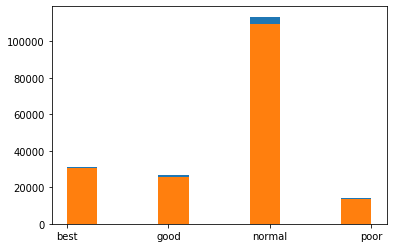

In [5]:
data = df.copy()
labels = ['poor', 'normal', 'good', 'best']
data["label"] = pd.cut(data["upvotes"], bins=[-np.inf, 0., 3, 9, np.inf], labels=labels)
plt.hist(data["label"].values.tolist())
data = data.loc[data['comment_body'].apply(lambda x: len(x) <= 512), :]
plt.hist(data["label"].values.tolist())
plt.show()

# Preprocessing

Further preprocessing and getting the one hot encodings

In [6]:
def preprocess(df, labels, size, charlimit): #Use size parameter to get smaller version of the dataset 
    # and char limit for filtering out text exceeding the limit
    data = df.copy()
    data = clean(data)
    data = data.loc[data['comment_body'].apply(lambda x: len(x) <= charlimit), :]
    data["label"] = pd.cut(data["upvotes"], bins=[-np.inf, 0., 3, 9, np.inf], labels=labels)
    data["text"] = data['comment_body']
    label_cols = pd.get_dummies(data["label"])
    data = data.drop(columns=['label', 'comment_body', 'upvotes'])
    data = pd.concat([data, label_cols], axis=1)
    return data.reset_index(drop=True)

In [7]:
fastdata = preprocess(df, ['poor', 'normal', 'good', 'best'], df.shape[0], 512)
flairdata = preprocess(df, ['__label__poor', '__label__normal', '__label__good', '__label__best'], df.shape[0], 512)
flairdata.head(10)

,text,__label__poor,__label__normal,__label__good,__label__best
0,Peter Quill and Gamora will NOT end up togethe...,0,0,0,1
1,The opening scene of Ant-Man 3 will be Luis as...,0,0,0,1
2,Latveria (but not Dr. Doom yet) will be introd...,0,0,1,0
3,Gamma radiation will create mutantsWe know tha...,0,1,0,0
4,Kathryn Hahn is almost certainly Agatha Harkne...,0,1,0,0
5,"Plus, it's not like it has to be cheesy or bor...",0,0,1,0
6,Yes please. Remember how awesome the musical n...,0,1,0,0
7,Honestly I would adore an mcu musical!,0,1,0,0
8,"Meh. ""Villain has the same powers as the hero ...",0,1,0,0
9,This is brilliant! I'd love to see Scott do th...,0,0,0,1


In [8]:
def savedata(data, trainpath, testpath, flag):
    #data = data.reset_index(drop=True)
    splitby = int(0.8*len(data))
    train_data = data[:splitby]
    if flag:
        splitby1 = int(0.9*len(data))
        test_data = data[splitby:splitby1]
        val_data = data[splitby1:]
        val_data = val_data.dropna().reset_index(drop=True)
        val_data.to_csv("flairdata/val.csv", index=False)
    else:
        test_data = data[splitby:]
    train_data = train_data.dropna().reset_index(drop=True)
    test_data = test_data.dropna().reset_index(drop=True)
    train_data.to_csv(trainpath, index=False)
    test_data.to_csv(testpath, index=False)

In [9]:
savedata(fastdata, "fastdata/train.csv", "fastdata/test.csv", 0)
savedata(flairdata, "flairdata/train.csv", "flairdata/test.csv", 1)

# EDA

Using nltk's word tokenizer and collections libraries to tokenize and observe the most common words in each 'category'

In [10]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

#import nltk
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#nltk.download('punkt')

def mostcommon(given):
    giventext = " ".join(list(given))
    tokens = word_tokenize(giventext)
    tokens = [x.lower() for x in tokens if x.lower() not in stop_words]
    tokens = [re.sub('[\:\’\.,?!/()&]', '', x) for x in tokens]
    tokens = [x for x in tokens if x != '']
    #Return top 10 words
    return Counter(tokens).most_common()[:10]

In [11]:
for i, j in enumerate(labels):
    print()
    print(j)
    print()
    print(mostcommon(data.loc[data['label'].apply(lambda x: x == j), 'comment_body']))


poor

[("n't", 2701), ("'s", 2575), ('like', 1850), ('movie', 1329), ('marvel', 1162), ('people', 1144), ('would', 1017), ('one', 992), ('think', 858), ('movies', 841)]

normal

[("'s", 17764), ("n't", 13951), ('like', 11918), ('would', 9573), ('movie', 8186), ('one', 7807), ('marvel', 7106), ('mcu', 6637), ('see', 6450), ('think', 6169)]

good

[("'s", 5214), ("n't", 4039), ('like', 3098), ('would', 2497), ('movie', 2017), ('one', 1893), ('think', 1765), ('``', 1628), ("''", 1543), ('marvel', 1541)]

best

[("'s", 6243), ("n't", 4156), ('like', 3444), ('would', 2794), ('``', 2304), ('one', 2270), ("''", 2114), ('movie', 2057), ('think', 1909), ('see', 1638)]
